# [Computational Social Science] Project 4: Unsupervised Learning

**Enter your Name:** Taylor Brown

*Semester:* Fall 2023

## Data Description and Preprocessing

For this project, you will explore data from the [National Health and Nutrition Examination Survey](https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey?select=questionnaire.csv). NHANES is a unique study that combines survey methodology with in-person medical examinations to create a dataset with demographic information, health indicators, and health outcomes.

We start by importing the data and doing some preliminary preprocessing for you. We import some libraries that will be helpful as well. 'SEQN' is the ID number for each respondent, and 'HSD010' will be our target outcome. [HSD010](https://wwwn.cdc.gov/Nchs/Nhanes/2013-2014/HSQ_H.htm#HSD010) asks for the respondent's self reported health condition, which can range from "excellent" to "poor."

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.model_selection import train_test_split
sns.set_style("darkgrid")
from sklearn.model_selection import train_test_split
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics
from scipy.spatial.distance import cdist

In [2]:
# Load nhanes data
nhanes = pd.read_csv('nhanes.csv')
# Get the ID numbers for each observation (seqn)
seqn = nhanes['SEQN']
# Get the target, "self-reported health condition," HSD010
hsd010 = nhanes['HSD010']
# Drop SEQN from the dataframe and then apply the standard scaler
nhanes = nhanes.drop(['SEQN', 'HSD010'], axis = 1)
nhanes_scaled = pd.DataFrame(StandardScaler().fit_transform(nhanes),
                             columns = nhanes.columns)
# Add the ID and target back in
nhanes_scaled['SEQN'] = seqn
nhanes_scaled['HSD010'] = hsd010
nhanes_scaled = nhanes_scaled.set_index('SEQN')
nhanes_scaled.head()

,DR1DRSTZ,DR1EXMER,DRABF,DRDINT,DR1DBIH,DR1DAY,DR1LANG,DR1MNRSP,DR1HELPD,DBQ095Z,...,OHQ770,OHQ845,PAAQUEX,SMQ860,SMQ870,SMQ872,SMQ874,SMQ878,SMAQUEX.x,HSD010
SEQN,,,,,,,,,,,,,,,,,,,,,
73568,0.0,2.034312,0.0,0.324834,-0.393906,1.085853,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-0.646584,-0.484200,1.125008,0.0,-2.081666,1.087115,1.463404,0.612440,1
73576,0.0,0.261930,0.0,-3.078499,0.568251,0.634362,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-1.539259,-0.484200,1.125008,0.0,-2.081666,1.087115,-0.683338,-1.632812,1
73579,0.0,0.728346,0.0,0.324834,1.530407,-1.623092,-0.194202,-0.057306,0.128246,-0.189513,...,0.383802,-1.539259,2.065262,-0.888883,0.0,0.480384,-0.919866,-0.683338,-1.632812,2
73581,0.0,-0.857470,0.0,0.324834,0.480782,1.085853,-0.194202,-0.057306,0.128246,0.080373,...,0.383802,-0.646584,-0.484200,1.125008,0.0,0.480384,-0.919866,-0.683338,0.612440,2
73584,0.0,0.495138,0.0,0.324834,0.305844,-1.623092,-0.194202,-0.057306,0.128246,0.080373,...,-2.605509,0.246091,2.065262,1.125008,0.0,0.480384,-0.919866,1.463404,-1.632812,3


## Plots

Let's take a look at the data. Below we visualize boxplots of family income to federal poverty line ratio ('INDFMPIR') and self-reported health condition. Notice how there are some clear patterns (the lower the ratio, the lower reported health condition), but it's not a perfect separation. We have 240+ features in our dataset, and we likely have several features in our dataset that highly correlate with our family income-poverty line ratio measure - PCA will help us simplify these.

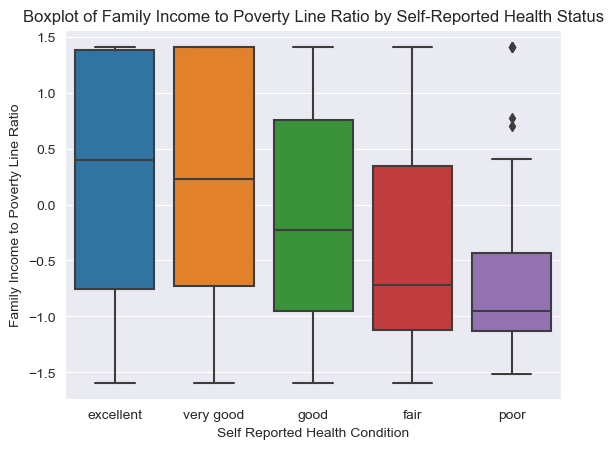

In [3]:
# Create a binary version of hsd010 where 1-3 are "good" and 4-5 are "poor"
nhanes_scaled['HSD010_binary'] = hsd010_binary = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['good', 'good', 'good', 'poor', 'poor']) 
# Recode the original hsd010 with the string labels
nhanes_scaled['HSD010'] = nhanes_scaled['HSD010'].replace(
    [1, 2, 3, 4, 5], ['excellent', 'very good', 'good', 'fair', 'poor'])
# Boxplot of hsd010
ax = sns.boxplot(x = 'HSD010', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Self-Reported Health Status")
plt.show()

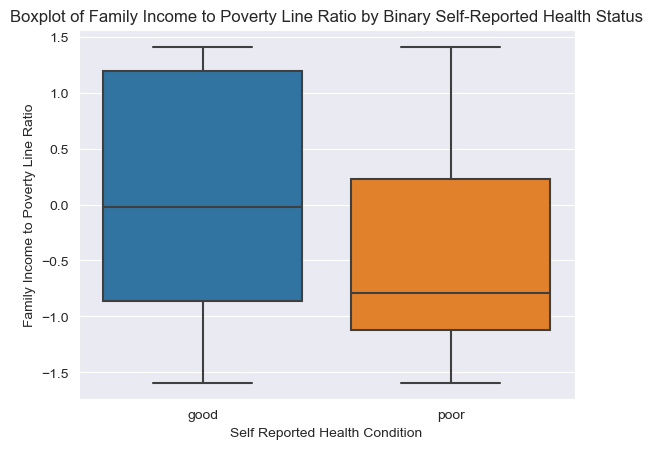

In [4]:
# Boxplot of hsd010_binary
ax = sns.boxplot(x = 'HSD010_binary', y = 'INDFMPIR', data = nhanes_scaled)
ax.set(xlabel = "Self Reported Health Condition",
      ylabel = "Family Income to Poverty Line Ratio")
ax.set_title("Boxplot of Family Income to Poverty Line Ratio by Binary Self-Reported Health Status")
plt.show()

Family income also is not necessarily well correlated with measured health outcomes. See below where we look at the relationship between Body Mass Index (BMI) and the family income-poverty line ratio, and shade points by self-reported health condition. It's hard to find a clear pattern - this is where clustering may come in handy. 

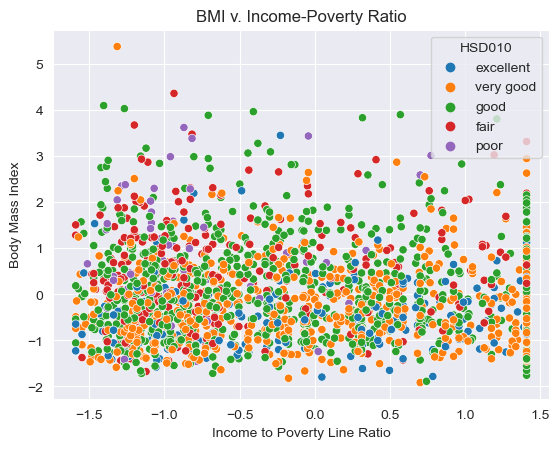

In [5]:
ax = sns.scatterplot(x = "INDFMPIR", y = "BMXBMI", hue = "HSD010", palette = "tab10", data = nhanes_scaled)
ax.set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
ax.set_title("BMI v. Income-Poverty Ratio")
plt.show()

Before we move to working on unsupervised methods, we'll drop our target variables again:

In [6]:
nhanes_scaled_X = nhanes_scaled.drop(['HSD010', 'HSD010_binary'], axis = 1)

## Principal Component Analysis

Conduct a Principal Component Analysis (PCA) of the nhanes data. The data has already been prepared for you, so you can work directly on nhanes_scaled. Be sure to do the following:

- Choose the number of components and provide 1-2 sentences about your choice of the number of components. 
- Plot a barplot of the variation explained by each component. *Hint*: look at the attributes associated with your model. 
- Choose how many components you will use to fit a supervised learning model and provide 1-2 sentences to explain that choice.
- Plot a 2D scatterplot of the first two components and provide 1-2 sentences analyzing the plot.

### Train PCA and Discuss Number of Components

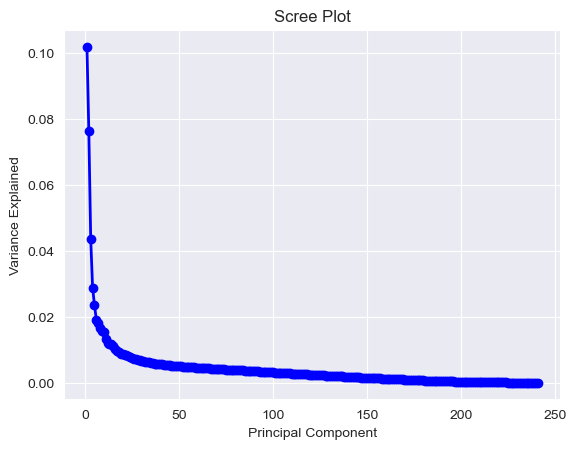

In [7]:
# fit PCA without specifying the number of components

pca_all = PCA(random_state = 123)
principalComponents = pca_all.fit_transform(nhanes_scaled_X)


# create scree plot from PCA fit

PC_values = np.arange(pca_all.n_components_) + 1
plt.plot(PC_values, pca_all.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

I think I'm going to keep the first six components because at the sixth component, the proportion of variance added by each additional component seems to significantly drop and begin to approach zero.

### Barplot of Components

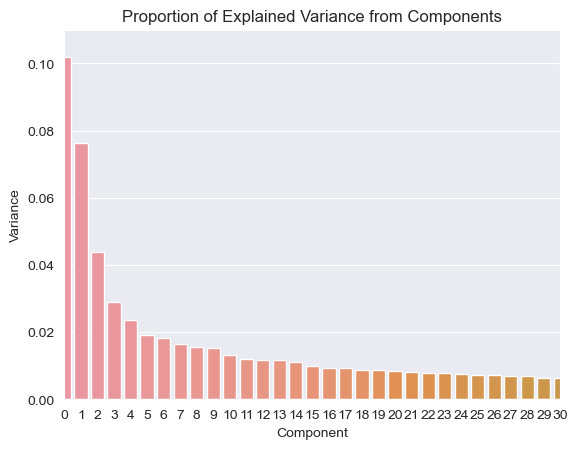

In [8]:
# Boxplot of components

component = np.arange(pca_all.n_components_)
variance = pca_all.explained_variance_ratio_
variance_df = pd.DataFrame({'component':component, 'variance':variance})


plt_comp = sns.barplot(x = 'component', y = 'variance', data = variance_df)
plt_comp.set(xlabel = "Component",
             ylabel = "Variance")
plt_comp.set_title("Proportion of Explained Variance from Components")
plt_comp.axis([0, 30, 0, .11])
plt.show()

I'm actually just going to keep the first five components because the difference between five and six seems negligible and their variance contribution is already below 0.02.

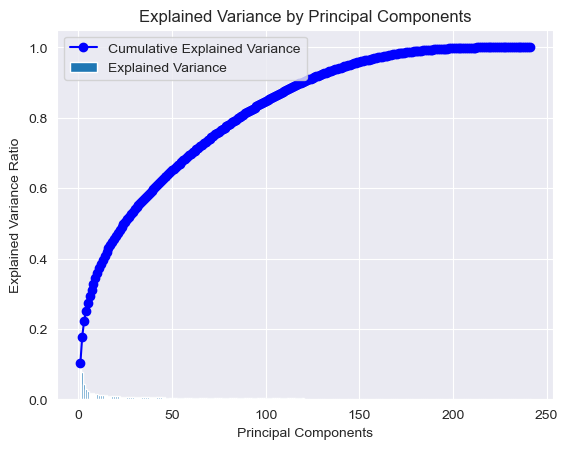

In [9]:
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca_all.explained_variance_ratio_)

# Barplot of the explained variance for each component
plt.bar(range(1, len(cumulative_explained_variance) + 1), pca_all.explained_variance_ratio_, label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label='Cumulative Explained Variance', marker='o', color='blue')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()

No, I think I'll use four components instead.

### How many components will you use to fit a supervised learning model?

In [10]:
# train PCA with only five components

pca = PCA(n_components = 4,
         random_state = 123)
principalComponents = pca.fit_transform(nhanes_scaled_X)

# convert factor loadings into a dataframe

pca_df = pd.DataFrame(data = principalComponents, 
                      columns = ['principal component 1', 
                                 'principal component 2',
                                 'principal component 3',
                                 'principal component 4'])

# view factor loadings as dataframe
pca_df.head()

,principal component 1,principal component 2,principal component 3,principal component 4
0,9.527811,-0.816225,-1.867040,-2.109119
1,-5.838338,-3.692570,3.805838,-1.029993
2,-0.719454,-2.573199,0.907841,-4.756262
3,3.533627,-2.576981,-3.248977,-0.405449
4,-6.872094,-4.194242,0.886703,-0.848609


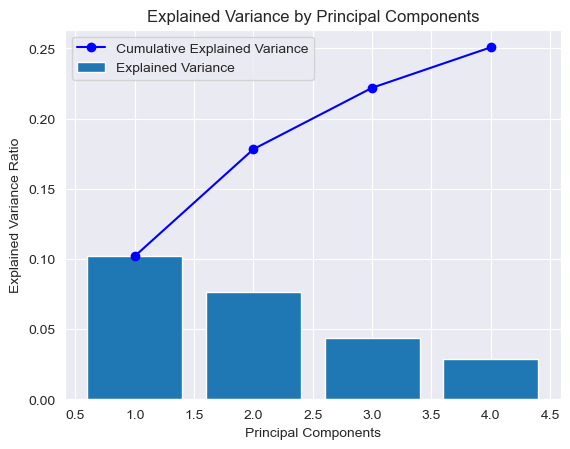

In [11]:
# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Barplot of the explained variance for each component
plt.bar(range(1, len(cumulative_explained_variance) + 1), pca.explained_variance_ratio_, label='Explained Variance')
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label='Cumulative Explained Variance', marker='o', color='blue')

plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.show()

### 2D Scatterplot of the first two components

<Figure size 640x480 with 0 Axes>

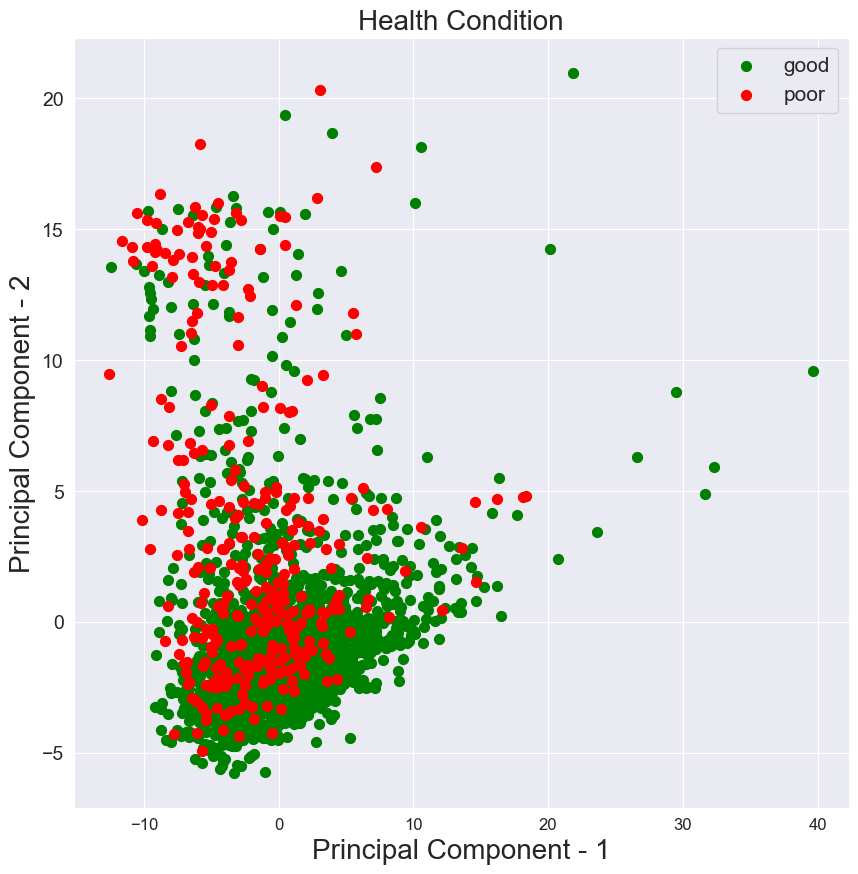

In [12]:
# needed to reset the index because one of the variables was mistakeningly made an index
nhanes_scaled = nhanes_scaled.reset_index()

# create new dataset
nhanes_pca = nhanes_scaled.join(pca_df)

# plot
# ----------

# figure settings
plt.figure()
plt.figure(figsize=(10,10))
plt.xticks(fontsize=12)
plt.yticks(fontsize=14)
plt.xlabel('Principal Component - 1',fontsize=20)
plt.ylabel('Principal Component - 2',fontsize=20)
plt.title("Health Condition",fontsize=20)
targets = ['good', 'poor']
colors = ['g', 'r']

# loop over targets and colors to create scatterplot
for target, color in zip(targets,colors):
    indicesToKeep = nhanes_pca['HSD010_binary'] == target
    plt.scatter(nhanes_pca.loc[indicesToKeep, 'principal component 1']
               , nhanes_pca.loc[indicesToKeep, 'principal component 2'], c = color, s = 50)

# show figure
plt.legend(targets,prop={'size': 15})
plt.show();

## K-Means

- Choose a clustering algorithm and explain it in 1-2 sentences.
- Cluster the nhanes data. Detail any choice you need to make with regards to number of clusters, and how you arrived at that choice. For instance, you might use the [elbow method](https://en.wikipedia.org/wiki/Elbow_method_(clustering)) if you choose k-means.
- Plot your clusters on top of BMI v. Income Poverty Ratio Plot. Describe what you see in 1-2 sentences.
- Retrain the clustering algorithm, but this time use your PCA results instead of the original dataframe. Plot the clusters on top of the 2D PCA scatterplot from the previous step. Describe your results in 1-2 sentences.

### Choose a Clustering Algorithm

I chose the K-means clustering algorithm. Essentially, this algorithm selects K cluster centroids and then classifies each data point in respect to the closest cluster centroid.

### Cluster nhanes

/Users/Taylor_1/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Taylor_1/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Taylor_1/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Taylor_1/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/T

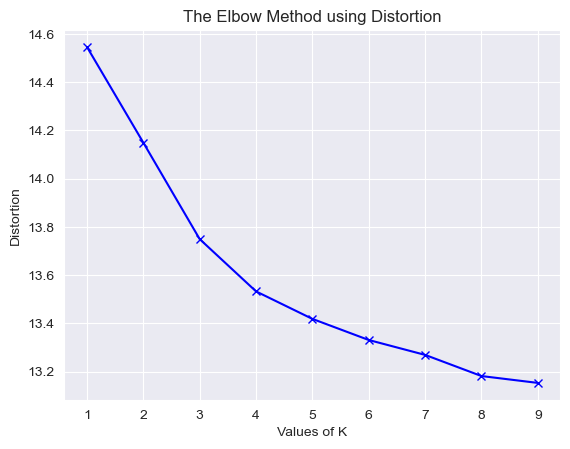

In [13]:
# I've used the elbow method as shared by AlindGupta at https://www.geeksforgeeks.org/elbow-method-for-optimal-value-of-k-in-kmeans/

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(nhanes_scaled_X)
    kmeanModel.fit(nhanes_scaled_X)
 
    distortions.append(sum(np.min(cdist(nhanes_scaled_X, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / nhanes_scaled_X.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(nhanes_scaled_X, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / nhanes_scaled_X.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

Following the elbow method, I've chosen to arbitrarly set the number of clusters at four because it seems that this may be the point where there are diminising returns in terms of explained variance for each additional cluster.

In [14]:
kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300,
                random_state = 123,
                ).fit(nhanes_scaled_X)

kmeans_df = pd.DataFrame(kmeans.labels_, columns = ['cluster'])

old_cluster = [0, 1, 2, 3]
new_cluster = [1, 2, 3, 4]
kmeans_df['cluster'] = kmeans_df['cluster'].replace(old_cluster, new_cluster)

nhanes_kmeans = nhanes_scaled.join(kmeans_df)

### Plot your clusters on top of the BMI v. Income Poverty Ratio Plot

In [15]:
X2 = nhanes_scaled_X[['INDFMPIR', 'BMXBMI']]
X2 = X2.reset_index().drop(['SEQN'], axis = 1)

kmeans = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300 #default
                ).fit(X2)

kmeans_sel_df = pd.DataFrame(kmeans.labels_, columns = ['cluster'])

old_cluster = [0, 1, 2, 3]
new_cluster = [1, 2, 3, 4]
kmeans_sel_df['cluster'] = kmeans_sel_df['cluster'].replace(old_cluster, new_cluster)

nhanes_sel_kmeans = X2.join(kmeans_sel_df)

centroids = kmeans.cluster_centers_

centroids = pd.DataFrame(centroids,
                         columns = ['INDFMPIR', 'BMXBMI'])

cluster = [1, 2, 3, 4]

centroids['centroid'] = cluster

/var/folders/mm/_cx1_9js4zdgtf0627n62rkm0000gn/T/ipykernel_8726/1939307239.py:3: UserWarning: 
The markers list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x = 'INDFMPIR', y = 'BMXBMI', hue = 'centroid', palette = "tab10", data = centroids, s = 100, style = 'centroid', markers = 's').set_title("BMI v. Income-Poverty Ratio by KMeans Cluster")


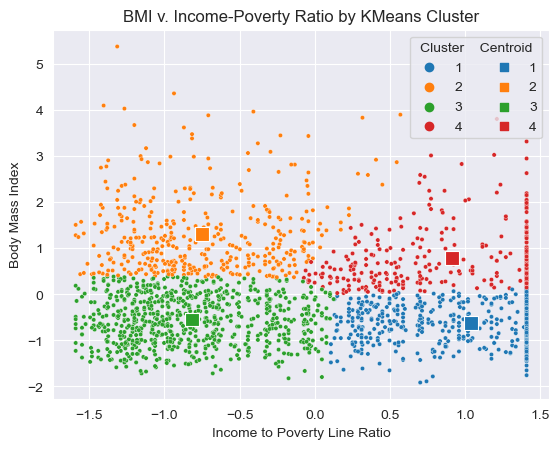

In [16]:
sns.scatterplot(x = 'INDFMPIR', y = 'BMXBMI', hue = "cluster", palette = "tab10", data = nhanes_sel_kmeans, s = 10).set(xlabel = "Income to Poverty Line Ratio",
      ylabel = "Body Mass Index")
sns.scatterplot(x = 'INDFMPIR', y = 'BMXBMI', hue = 'centroid', palette = "tab10", data = centroids, s = 100, style = 'centroid', markers = 's').set_title("BMI v. Income-Poverty Ratio by KMeans Cluster")

plt.legend(ncols = 2, title = 'Cluster    Centroid')
plt.show()

### Retrain the clustering algorithm on PCA components and plot clusters on your 2D scatter

/Users/Taylor_1/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Taylor_1/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Taylor_1/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/Taylor_1/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/Users/T

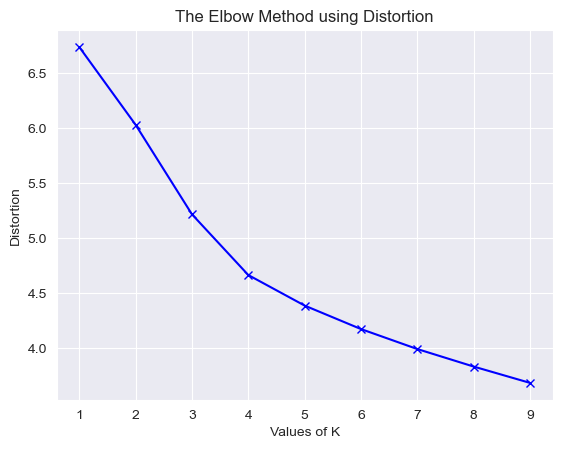

In [17]:
nhanes_kmeans_pca = nhanes_pca[['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4']]

distortions = []
inertias = []
mapping1 = {}
mapping2 = {}
K = range(1, 10)
 
for k in K:
    # Building and fitting the model
    kmeanModel = KMeans(n_clusters=k).fit(nhanes_kmeans_pca)
    kmeanModel.fit(nhanes_kmeans_pca)
 
    distortions.append(sum(np.min(cdist(nhanes_kmeans_pca, kmeanModel.cluster_centers_,
                                        'euclidean'), axis=1)) / nhanes_kmeans_pca.shape[0])
    inertias.append(kmeanModel.inertia_)
 
    mapping1[k] = sum(np.min(cdist(nhanes_kmeans_pca, kmeanModel.cluster_centers_,
                                   'euclidean'), axis=1)) / nhanes_kmeans_pca.shape[0]
    mapping2[k] = kmeanModel.inertia_

plt.plot(K, distortions, 'bx-')
plt.xlabel('Values of K')
plt.ylabel('Distortion')
plt.title('The Elbow Method using Distortion')
plt.show()

In [18]:
kmeans_pca = KMeans(n_clusters=4,
                n_init=10,
                max_iter=300,
                random_state = 123
                ).fit(nhanes_kmeans_pca)

kmeans_pca_df = pd.DataFrame(kmeans.labels_, columns = ['cluster'])

old_cluster = [0, 1, 2, 3]
new_cluster = [1, 2, 3, 4]
kmeans_pca_df['cluster'] = kmeans_pca_df['cluster'].replace(old_cluster, new_cluster)

nhanes_kmeans_pca = nhanes_kmeans_pca.join(kmeans_pca_df)

centroids = kmeans_pca.cluster_centers_

centroids = pd.DataFrame(centroids,
                         columns = ['principal component 1', 'principal component 2', 'principal component 3', 'principal component 4'])

cluster = [2, 1, 4, 3]

centroids['centroid'] = cluster

/var/folders/mm/_cx1_9js4zdgtf0627n62rkm0000gn/T/ipykernel_8726/2112782171.py:3: UserWarning: 
The markers list has fewer values (1) than needed (4) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x = 'principal component 1', y = 'principal component 2', hue = 'centroid', palette = "tab10", data = centroids, s = 100, style = 'centroid', markers = 's').set_title("Principal Component 1 and Principal Component 2 by KMeans Cluster")


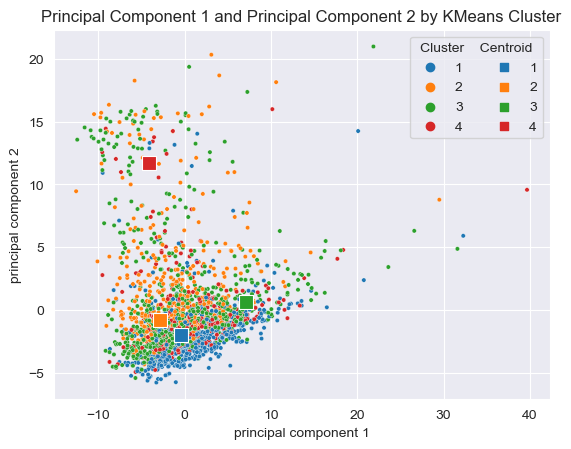

In [19]:
sns.scatterplot(x = 'principal component 1', y = 'principal component 2', hue = "cluster", palette = "tab10", data = nhanes_kmeans_pca, s = 10).set(xlabel = "principal component 1",
      ylabel = "principal component 2")
sns.scatterplot(x = 'principal component 1', y = 'principal component 2', hue = 'centroid', palette = "tab10", data = centroids, s = 100, style = 'centroid', markers = 's').set_title("Principal Component 1 and Principal Component 2 by KMeans Cluster")

plt.legend(ncols = 2, title = 'Cluster    Centroid')
plt.show()

## Neural Network

Now we are ready to predict! Do the following:

- Choose either HSD010 or HSD010\_binary as your target outcome.  
- Train a neural network using the original features. Much of the code to train a basic neural net has been set up for you, but you will need to fill in a couple of missing pieces.
- Train a neural network using only your PCA components as features.
- Train a neural network using your PCA components and the predicted class membership from your clustering algorithm as features.
- Compare and contrast how well each algorithm did. Which featurization technique would you pick and why?

Below we provide a template for training a neural network. Use this template for training on the original features, on the PCA components, and the PCA components + the predicted classes from your clusters.

### Neural Network on Original Features

In [20]:
# partition data
# -----------
y = nhanes_scaled[['HSD010_binary']] # either hsd010 or hsd010_binary, may need to convert to numeric if it isn't already
y = hsd010_binary = y.replace(
    ['good', 'poor'], [0, 1]) 

X = nhanes_scaled_X # drop out any columns that aren't features

X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = .25, 
                                                    random_state = 10)

In [21]:
# load libraries
# -----------
import keras
from keras.utils import to_categorical

num_classes = 2
# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
num_classes = y_test.shape[1]

In [22]:
# create neural network model
# -----------
model = Sequential()

model.add(Dense(X_train.shape[1], input_dim = X_train.shape[1], kernel_initializer = 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer = 'normal', activation = 'softmax'))

## Add any additional layers you wish here

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train, y_train, validation_data = (X_test, y_test), epochs = 10, batch_size = 200, verbose = 2)

Epoch 1/10
8/8 - 0s - loss: 0.5077 - accuracy: 0.7784 - val_loss: 0.3763 - val_accuracy: 0.8450 - 187ms/epoch - 23ms/step
Epoch 2/10
8/8 - 0s - loss: 0.3503 - accuracy: 0.8611 - val_loss: 0.3563 - val_accuracy: 0.8624 - 19ms/epoch - 2ms/step
Epoch 3/10
8/8 - 0s - loss: 0.3104 - accuracy: 0.8734 - val_loss: 0.3474 - val_accuracy: 0.8721 - 21ms/epoch - 3ms/step
Epoch 4/10
8/8 - 0s - loss: 0.2731 - accuracy: 0.8889 - val_loss: 0.3352 - val_accuracy: 0.8721 - 20ms/epoch - 3ms/step
Epoch 5/10
8/8 - 0s - loss: 0.2426 - accuracy: 0.9044 - val_loss: 0.3298 - val_accuracy: 0.8682 - 22ms/epoch - 3ms/step
Epoch 6/10
8/8 - 0s - loss: 0.2203 - accuracy: 0.9134 - val_loss: 0.3284 - val_accuracy: 0.8721 - 20ms/epoch - 3ms/step
Epoch 7/10
8/8 - 0s - loss: 0.1993 - accuracy: 0.9244 - val_loss: 0.3317 - val_accuracy: 0.8682 - 21ms/epoch - 3ms/step
Epoch 8/10
8/8 - 0s - loss: 0.1805 - accuracy: 0.9360 - val_loss: 0.3311 - val_accuracy: 0.8760 - 22ms/epoch - 3ms/step
Epoch 9/10
8/8 - 0s - loss: 0.1627 - a

### Neural Network on Principal Components

In [23]:
X_pca = pca_df

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca,
                                                                    y,
                                                                    test_size = .25,
                                                                    random_state = 10)

num_classes = 2
y_train_pca = keras.utils.to_categorical(y_train_pca, num_classes)
y_test_pca = keras.utils.to_categorical(y_test_pca, num_classes)
num_classes = y_test_pca.shape[1]

model = Sequential()

model.add(Dense(X_train_pca.shape[1], input_dim = X_train_pca.shape[1], kernel_initializer = 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer = 'normal', activation = 'softmax'))

## Add any additional layers you wish here

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train_pca, y_train_pca, validation_data = (X_test_pca, y_test_pca), epochs = 10, batch_size = 200, verbose = 2)

Epoch 1/10
8/8 - 0s - loss: 0.7054 - accuracy: 0.2481 - val_loss: 0.6985 - val_accuracy: 0.5329 - 154ms/epoch - 19ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6936 - accuracy: 0.6195 - val_loss: 0.6874 - val_accuracy: 0.7229 - 15ms/epoch - 2ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6830 - accuracy: 0.7519 - val_loss: 0.6770 - val_accuracy: 0.8140 - 15ms/epoch - 2ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6729 - accuracy: 0.8198 - val_loss: 0.6672 - val_accuracy: 0.8391 - 16ms/epoch - 2ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6631 - accuracy: 0.8340 - val_loss: 0.6575 - val_accuracy: 0.8430 - 15ms/epoch - 2ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6534 - accuracy: 0.8353 - val_loss: 0.6476 - val_accuracy: 0.8488 - 15ms/epoch - 2ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6433 - accuracy: 0.8353 - val_loss: 0.6372 - val_accuracy: 0.8488 - 17ms/epoch - 2ms/step
Epoch 8/10
8/8 - 0s - loss: 0.6325 - accuracy: 0.8359 - val_loss: 0.6260 - val_accuracy: 0.8488 - 17ms/epoch - 2ms/step
Epoch 9/10
8/8 - 0s - loss: 0.6207 - a

### Neural Network on Principal Components + Cluster Membership

In [24]:
X_pca_cluster = nhanes_kmeans_pca

X_train_pca_cluster, X_test_pca_cluster, y_train_pca_cluster, y_test_pca_cluster = train_test_split(X_pca_cluster,
                                                                                                    y,
                                                                                                    test_size = .25,
                                                                                                    random_state = 10)

num_classes = 2
y_train_pca_cluster = keras.utils.to_categorical(y_train_pca_cluster, num_classes)
y_test_pca_cluster = keras.utils.to_categorical(y_test_pca_cluster, num_classes)
num_classes_cluster = y_test_pca_cluster.shape[1]

model = Sequential()

model.add(Dense(X_train_pca_cluster.shape[1], input_dim = X_train_pca_cluster.shape[1], kernel_initializer = 'normal', activation= 'relu'))

model.add(Dense(num_classes, kernel_initializer = 'normal', activation = 'softmax'))

## Add any additional layers you wish here

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

model.fit(X_train_pca_cluster, y_train_pca_cluster, validation_data = (X_test_pca_cluster, y_test_pca_cluster), epochs = 10, batch_size = 200, verbose = 2)

Epoch 1/10
8/8 - 0s - loss: 0.7064 - accuracy: 0.4322 - val_loss: 0.6981 - val_accuracy: 0.5465 - 147ms/epoch - 18ms/step
Epoch 2/10
8/8 - 0s - loss: 0.6929 - accuracy: 0.6053 - val_loss: 0.6842 - val_accuracy: 0.7074 - 13ms/epoch - 2ms/step
Epoch 3/10
8/8 - 0s - loss: 0.6790 - accuracy: 0.7487 - val_loss: 0.6687 - val_accuracy: 0.8275 - 12ms/epoch - 2ms/step
Epoch 4/10
8/8 - 0s - loss: 0.6629 - accuracy: 0.8230 - val_loss: 0.6516 - val_accuracy: 0.8469 - 14ms/epoch - 2ms/step
Epoch 5/10
8/8 - 0s - loss: 0.6453 - accuracy: 0.8340 - val_loss: 0.6324 - val_accuracy: 0.8488 - 14ms/epoch - 2ms/step
Epoch 6/10
8/8 - 0s - loss: 0.6253 - accuracy: 0.8359 - val_loss: 0.6112 - val_accuracy: 0.8488 - 13ms/epoch - 2ms/step
Epoch 7/10
8/8 - 0s - loss: 0.6034 - accuracy: 0.8359 - val_loss: 0.5883 - val_accuracy: 0.8488 - 14ms/epoch - 2ms/step
Epoch 8/10
8/8 - 0s - loss: 0.5801 - accuracy: 0.8359 - val_loss: 0.5641 - val_accuracy: 0.8488 - 13ms/epoch - 2ms/step
Epoch 9/10
8/8 - 0s - loss: 0.5556 - a

## Discussion Questions

1. In your own words, what is the difference between PCA and clustering?

PCA reduces a set of features into a smaller, more managable set of variables, where clustering groups data based on their euclidean (generally) proximity to one another.

2. Did you notice any advantages to combining PCA and clustering? If so, what do you think they were? If not, why do you think you didn't see any gains from this combination?

Not surprisingly, my prediction accuracy was considerably lower in the PCA models compared to the full model. This is because I excluded many of the components that accounted for some of the explained variance in the outcome. I'm also not exactly sure, at this time, how to specify these neural networks to enhance prediction accuracy.

In this case, I think I would go with the model without the PCA and cluster prediction variables.

For me, the use of PCA has to make sense theoretically. If we had a lot of features related to a similar concept, then it might make sense to reduce them so that you can interpret the relation between the components and the outcome in terms of that reduced concept. I would also prefer to use more interpretable models with PCA like a basic OLS model so that it is easier to interpret the relationships between components and the outcome.

3. How can unsupervised techniques help with downstream supervised learning tasks when working with "big data?"

PCA and clustering may be instrumental for exploratory data analysis with big data. These methods of unsupervised learning can often help researchers manipuate their data into more interpretable and even more predictive ways that avoid some of the pitfalls of feature engineering. However, I would generally caution the flippant use of these methods for analysis without a strong theoretical justification. It can be easy to reduce a bunch of features or build clusters without really understanding what the new measures represent.